In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genaik2025-aylin/results_clean_v2.txt
/kaggle/input/genaik2025-aylin/summary_clean_v2.txt
/kaggle/input/genaik2025-aylin/cypher_query_v2.txt
/kaggle/input/genaik2025-aylin/summary_clean.txt
/kaggle/input/genaik2025-aylin/results_clean.txt
/kaggle/input/genaik2025-aylin/cypher_query.txt
/kaggle/input/genaik2025-aylin/neo4j_query_table_data_2024-10-12.csv


# Sources:
- For working with Ollama in Kaggle notebook: https://www.kaggle.com/code/sumanmichael/ollama-langchain-in-kaggle-gpu

In [2]:
!pip install --upgrade --quiet pyvis
!pip install --upgrade --quiet wordcloud matplotlib nltk
!pip install --upgrade --quiet wikipedia
!pip install --upgrade --quiet langchain
!pip install --upgrade --quiet langchain-community
!pip install --upgrade --quiet tiktoken
!pip install --upgrade --quiet matplotlib seaborn
!pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j
!pip install --upgrade --quiet huggingface_hub
!pip install --upgrade --quiet langchain-huggingface
!pip install --upgrade --quiet json-repair
!pip install --upgrade --quiet langchain-groq

print(" ********** SUCCESSFULLY INSTALLED ALL THE LIBRARIES AND MODULES ********** ") 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.1 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which 

In [3]:
from langchain_community.graphs import Neo4jGraph
from langchain_community.chat_models import ChatOllama
from langchain.document_loaders import WikipediaLoader
from langchain_community.llms import Ollama
from langchain.chains import LLMChain
from langchain.prompts.chat import (ChatPromptTemplate,HumanMessagePromptTemplate,SystemMessagePromptTemplate)
from langchain import PromptTemplate
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.schema import (SystemMessage,HumanMessage,AIMessage)
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
from getpass import getpass

In [12]:
query = "Geoffrey Hinton"
raw_documents = WikipediaLoader(query=query).load()

In [13]:
for doc in raw_documents:
    print(doc.metadata['source'])

https://en.wikipedia.org/wiki/Geoffrey_Hinton
https://en.wikipedia.org/wiki/H._E._Hinton
https://en.wikipedia.org/wiki/Ilya_Sutskever
https://en.wikipedia.org/wiki/Yoshua_Bengio
https://en.wikipedia.org/wiki/Yann_LeCun
https://en.wikipedia.org/wiki/Artificial_intelligence
https://en.wikipedia.org/wiki/ChatGPT
https://en.wikipedia.org/wiki/Existential_risk_from_AI
https://en.wikipedia.org/wiki/History_of_artificial_intelligence
https://en.wikipedia.org/wiki/AlexNet
https://en.wikipedia.org/wiki/Main_Page
https://en.wikipedia.org/wiki/Boltzmann_machine
https://en.wikipedia.org/wiki/Artificial_general_intelligence
https://en.wikipedia.org/wiki/Alex_Krizhevsky
https://en.wikipedia.org/wiki/P(doom)
https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine
https://en.wikipedia.org/wiki/Russ_Salakhutdinov
https://en.wikipedia.org/wiki/AI_alignment
https://en.wikipedia.org/wiki/Deep_learning
https://en.wikipedia.org/wik

In [ ]:
filtered_raw_documents = [raw_documents[i] for i in range(len(raw_documents)) if i not in [1, 10, 14]]
docs = " ".join([d.page_content for d in filtered_raw_documents]).replace("\n", "").replace("==", "")
# print(docs)

In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=30
)
split_docs = text_splitter.create_documents([docs])
# split_docs

In [6]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%####################                                     52.3%#################################                    75.5%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [7]:
import os
get_ipython().system = os.system

In [8]:
!ollama serve &

0

Couldn't find '/root/.ollama/id_ed25519'. Generating new private key.
Your new public key is: 

ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIN33TaT1vDW5ALs+tP8k1IBvRqiWdO6tIiXolufXlEYK



2024/10/12 07:24:13 routes.go:1153: INFO server config env="map[CUDA_VISIBLE_DEVICES: GPU_DEVICE_ORDINAL: HIP_VISIBLE_DEVICES: HSA_OVERRIDE_GFX_VERSION: HTTPS_PROXY: HTTP_PROXY: NO_PROXY: OLLAMA_DEBUG:false OLLAMA_FLASH_ATTENTION:false OLLAMA_GPU_OVERHEAD:0 OLLAMA_HOST:http://127.0.0.1:11434 OLLAMA_INTEL_GPU:false OLLAMA_KEEP_ALIVE:5m0s OLLAMA_LLM_LIBRARY: OLLAMA_LOAD_TIMEOUT:5m0s OLLAMA_MAX_LOADED_MODELS:0 OLLAMA_MAX_QUEUE:512 OLLAMA_MODELS:/root/.ollama/models OLLAMA_NOHISTORY:false OLLAMA_NOPRUNE:false OLLAMA_NUM_PARALLEL:0 OLLAMA_ORIGINS:[http://localhost https://localhost http://localhost:* https://localhost:* http://127.0.0.1 https://127.0.0.1 http://127.0.0.1:* https://127.0.0.1:* http://0.0.0.0 https://0.0.0.0 http://0.0.0.0:* https://0.0.0.0:* app://* file://* tauri://*] OLLAMA_SCHED_SPREAD:false OLLAMA_TMPDIR: ROCR_VISIBLE_DEVICES: http_proxy: https_proxy: no_proxy:]"
time=2024-10-12T07:24:13.585Z level=INFO source=images.go:753 msg="total blobs: 0"
time=2024-10-12T07:24:13.5

In [9]:
# Explore more ollama models here: https://ollama.com/library
!ollama pull mistral

[GIN] 2024/10/12 - 07:25:20 | 200 |      51.336µs |       127.0.0.1 | HEAD     "/"


pulling manifest ⠋ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠴ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ time=2024-10-12T07:25:22.200Z level=INFO source=download.go:175 msg="downloading ff82381e2bea in 16 257 MB part(s)"
pulling manifest 
pulling ff82381e2bea...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕                ▏  15 MB/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   3% ▕                ▏ 106 MB/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   5% ▕                ▏ 212 MB/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   7% ▕█               ▏ 268 MB/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   9% ▕█      

[GIN] 2024/10/12 - 07:25:50 | 200 | 29.317886418s |       127.0.0.1 | POST     "/api/pull"


pulling manifest 
pulling ff82381e2bea... 100% ▕████████████████▏ 4.1 GB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling 491dfa501e59... 100% ▕████████████████▏  801 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 42347cd80dc8... 100% ▕████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
success 


0

In [26]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter

llm = Ollama(model="mistral") # Define the mistral model

# Define the map prompt template
map_template = """The following is a set of documents
{all_data}
Based on this list of docs, please find the important information from it (focus on entities and relationship)
Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)

# Define the map_chain
map_chain = LLMChain(llm=llm, prompt=map_prompt)

reduce_template = """The following is set of summaries:
{all_data}
Take these and distill it into a final, consolidated summary of the main themes.
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain,
    document_variable_name="all_data"  # This should match the variable name in reduce_prompt
)

# Combines and iteravely reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=1024,
)

# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="all_data",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)


# Run the MapReduce Chain
summarization_results = map_reduce_chain.run(split_docs)

time=2024-10-10T08:11:08.327Z level=INFO source=server.go:103 msg="system memory" total="31.4 GiB" free="29.8 GiB" free_swap="0 B"
time=2024-10-10T08:11:08.328Z level=INFO source=memory.go:326 msg="offload to cpu" layers.requested=-1 layers.model=33 layers.offload=0 layers.split="" memory.available="[29.8 GiB]" memory.gpu_overhead="0 B" memory.required.full="5.5 GiB" memory.required.partial="0 B" memory.required.kv="1.0 GiB" memory.required.allocations="[5.5 GiB]" memory.weights.total="4.7 GiB" memory.weights.repeating="4.6 GiB" memory.weights.nonrepeating="105.0 MiB" memory.graph.full="560.0 MiB" memory.graph.partial="585.0 MiB"
time=2024-10-10T08:11:08.330Z level=INFO source=server.go:388 msg="starting llama server" cmd="/tmp/ollama1740820811/runners/cpu_avx2/ollama_llama_server --model /root/.ollama/models/blobs/sha256-ff82381e2bea77d91c1b824c7afb83f6fb73e9f7de9dda631bcdbca564aa5435 --ctx-size 8192 --batch-size 512 --embedding --log-disable --no-mmap --parallel 4 --port 35021"
time=

INFO [main] build info | build=10 commit="a8bb744" tid="138907934000064" timestamp=1728547868
INFO [main] system info | n_threads=2 n_threads_batch=2 system_info="AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | AVX512_BF16 = 0 | FMA = 1 | NEON = 0 | SVE = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | MATMUL_INT8 = 0 | LLAMAFILE = 1 | " tid="138907934000064" timestamp=1728547868 total_threads=4
INFO [main] HTTP server listening | hostname="127.0.0.1" n_threads_http="6" port="35021" tid="138907934000064" timestamp=1728547868


time=2024-10-10T08:11:08.583Z level=INFO source=server.go:621 msg="waiting for server to become available" status="llm server loading model"
llama_new_context_with_model: n_ctx      = 8192
llama_new_context_with_model: n_batch    = 512
llama_new_context_with_model: n_ubatch   = 512
llama_new_context_with_model: flash_attn = 0
llama_new_context_with_model: freq_base  = 1000000.0
llama_new_context_with_model: freq_scale = 1
llama_kv_cache_init:        CPU KV buffer size =  1024.00 MiB
llama_new_context_with_model: KV self size  = 1024.00 MiB, K (f16):  512.00 MiB, V (f16):  512.00 MiB
llama_new_context_with_model:        CPU  output buffer size =     0.56 MiB
llama_new_context_with_model:        CPU compute buffer size =   560.01 MiB
llama_new_context_with_model: graph nodes  = 1030
llama_new_context_with_model: graph splits = 1


INFO [main] model loaded | tid="138907934000064" timestamp=1728547872


time=2024-10-10T08:11:12.350Z level=INFO source=server.go:626 msg="llama runner started in 4.02 seconds"


[GIN] 2024/10/10 - 08:16:21 | 200 |         5m12s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 08:20:44 | 200 |         4m23s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 08:25:18 | 200 |         4m33s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 08:30:27 | 200 |          5m9s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 08:35:38 | 200 |         5m10s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 08:40:27 | 200 |         4m48s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 08:44:48 | 200 |         4m21s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 08:49:25 | 200 |         4m36s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 08:53:31 | 200 |          4m6s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 08:58:11 | 200 |         4m39s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 09:03:25 | 200 |         5m14s 

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (13106 > 1024). Running this sequence through the model will result in indexing errors


[GIN] 2024/10/10 - 10:46:55 | 200 |         5m40s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 10:52:08 | 200 |         5m12s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 10:57:54 | 200 |         5m46s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 11:03:43 | 200 |         5m49s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 11:08:16 | 200 |         4m32s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 11:13:50 | 200 |         5m33s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 11:18:31 | 200 |         4m41s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 11:23:42 | 200 |         5m11s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 11:29:23 | 200 |         5m40s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 11:32:43 | 200 |         3m20s |       127.0.0.1 | POST     "/api/generate"
[GIN] 2024/10/10 - 11:38:01 | 200 |         5m17s 

In [27]:
file_path = "summary.txt"

with open(file_path, 'a') as file:
    file.write(summarization_results)

In [15]:
from langchain_groq import ChatGroq
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass("Enter your Groq API key: ")

Enter your Groq API key:  ························································


In [54]:
entity_types = ['person', 'institution', 'award', 'invention', 'date', 'nationality', 'birthPlace', 'role', 'degree', 'characteristics', 'relation']

relation_types = ['coAuthored', 'worksAt', 'hasAward', 'coFounded', 'collaboratedWith', 'workedWith', 'developed',
                  'bornAt', 'bornIn', 'coFoundedAt', 'coFoundedIn', 'inventedAt', 'hasRole', 'earnedDegree', 'earnedDegreeFrom']

system_prompt = PromptTemplate(
    template = """
    You are a top-tier algorithm designed for extracting information in structured formats to build a knowledge graph.
    Your task is to identify the entities and relations requested with the user prompt, from a given text.
    You must generate the output in a JSON containing a list with JSON objects having the following keys: "head", "head_type", "relation", "tail", and "tail_type".
    The "head" key must contain the text of the extracted entity with one of the types from the provided list in the user prompt. 
    The "head_type" key must contain the type of the extracted head entity which must be one of the types from {entity_types}.
    The "relation" key must contain the type of relation between the "head" and the "tail" which must be one of the relations from {relation_types}.
    The "tail" key must represent the text of an extracted entity which is the tail of the relation, and the "tail_type" key must contain the type of the tail entity from {entity_types}. 
    Attempt to extract as many entities and relations as you can. 
    
    IMPORTANT NOTES:
    - Don't add any explanation and text. 
    """,
    input_variables=["entity_types","relation_types"],
)


system_message_prompt = SystemMessagePromptTemplate(prompt = system_prompt)

examples = [
    {
        "text": "Geoffrey Hinton co-authored a seminal paper in 1986 with David Rumelhart and Ronald J. Williams.",
        "head": "Geoffrey Hinton",
        "head_type": "person",
        "relation": "coAuthored",
        "tail": "David Rumelhart",
        "tail_type": "person"
    },
    {
        "text": "Hinton is a University Professor Emeritus at the University of Toronto.",
        "head": "Hinton",
        "head_type": "person",
        "relation": "worksAt",
        "tail": "University of Toronto",
        "tail_type": "institution"
    },
    {
        "text": "Hinton received the Turing Award.",
        "head": "Hinton",
        "head_type": "person",
        "relation": "hasAward",
        "tail": "Turing Award",
        "tail_type": "award"
    },
    {
        "text": "Hinton co-founded the Vector Institute.",
        "head": "Hinton",
        "head_type": "person",
        "relation": "coFounded",
        "tail": "Vector Institute",
        "tail_type": "institution"
    }
]

class ExtractedInfo(BaseModel):
    head: str = Field(description="extracted first or head entity like Noble prize, Vector Institute, Hinton")
    head_type: str = Field(description="type of the extracted head entity like person, company, etc")
    relation: str = Field(description="relation between the head and the tail entities")
    tail: str = Field(description="extracted second or tail entity like Noble, Vector Institute, Hinton")
    tail_type: str = Field(description="type of the extracted tail entity like person, company, etc")
    
parser = JsonOutputParser(pydantic_object=ExtractedInfo)

human_prompt = PromptTemplate(
    template = """ Based on the following example, extract entities and relations from the provided text.\n\n

    Use the following entity types, don't use other entity that is not defined below:
    # ENTITY TYPES:
    {entity_types}

    Use the following relation types, don't use other relation that is not defined below:
    # RELATION TYPES:
    {relation_types}

    Below are a number of examples of text and their extracted entities and relationshhips.
    {examples}

    For the following text, generate extract entitites and relations as in the provided example.\n{format_instructions}\nText: {text}""",
    input_variables=["entity_types","relation_types","examples","text"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

human_message_prompt = HumanMessagePromptTemplate(prompt=human_prompt)

chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])


# model = ChatOllama(model = "mistral",temperature=0)
# model = ChatOllama(model = "llama3",temperature=0)
model = ChatGroq(temperature=0, model_name="llama3-70b-8192")
chain = LLMChain(llm=model, prompt=chat_prompt)

In [55]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"head": {"title": "Head", "description": "extracted first or head entity like Noble prize, Vector Institute, Hinton", "type": "string"}, "head_type": {"title": "Head Type", "description": "type of the extracted head entity like person, company, etc", "type": "string"}, "relation": {"title": "Relation", "description": "relation between the head and the tail entities", "type": "string"}, "tail": {"title": "Tail", "description": "extracted second or tail entity like Noble, Vector Institute, Hinton", "type": "string"}, "tai

In [19]:
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


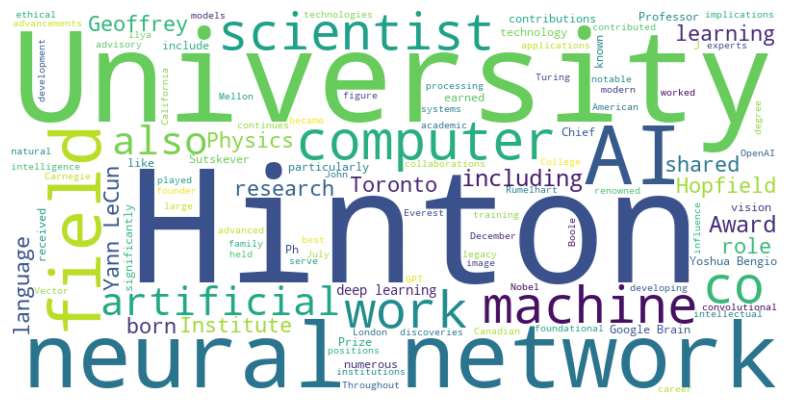

In [99]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

with open('/kaggle/input/genaik2025-aylin/summary_clean_v2.txt', 'r', encoding='utf-8') as file:
    text = file.read()

stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, min_font_size=10).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()


In [58]:
file_path = "/kaggle/input/genaik2025-aylin/summary_clean_v2.txt"
with open(file_path, 'r') as file:
    # Read the entire file contents into a string
    file_contents = file.read()

# Split the file contents into sentences
sentences = file_contents.split('. ')

result = []
# Iterate over each sentence
for sentence in tqdm(sentences):
    # Process each sentence
    response  = chain.run(entity_types = entity_types, relation_types = relation_types, examples = examples, text = sentence)
    print(response)
    try:
        result.extend(eval(response))
    except:
        pass

  3%|▎         | 1/37 [00:06<03:41,  6.14s/it]

[
    {
        "head": "Geoffrey Hinton",
        "head_type": "person",
        "relation": "bornIn",
        "tail": "London",
        "tail_type": "birthPlace"
    },
    {
        "head": "Geoffrey Hinton",
        "head_type": "person",
        "relation": "bornAt",
        "tail": "December 6, 1947",
        "tail_type": "date"
    },
    {
        "head": "Geoffrey Hinton",
        "head_type": "person",
        "relation": "worksAt",
        "tail": "University of Toronto",
        "tail_type": "institution"
    },
    {
        "head": "Geoffrey Hinton",
        "head_type": "person",
        "relation": "hasNationality",
        "tail": "British-Canadian",
        "tail_type": "nationality"
    },
    {
        "head": "Geoffrey Hinton",
        "head_type": "person",
        "relation": "hasRole",
        "tail": "cognitive psychologist and computer scientist",
        "tail_type": "role"
    }
]


  5%|▌         | 2/37 [00:19<06:08, 10.53s/it]

[
    {
        "head": "Hinton",
        "head_type": "person",
        "relation": "coAuthored",
        "tail": "David Rumelhart",
        "tail_type": "person"
    },
    {
        "head": "Hinton",
        "head_type": "person",
        "relation": "coAuthored",
        "tail": "Ronald J",
        "tail_type": "person"
    }
]


  8%|▊         | 3/37 [00:31<06:12, 10.96s/it]

[
    {
        "head": "Williams",
        "head_type": "person",
        "relation": "popularizing",
        "tail": "backpropagation algorithm",
        "tail_type": "invention"
    }
]


 11%|█         | 4/37 [00:43<06:20, 11.54s/it]

[
    {
        "head": "He",
        "head_type": "person",
        "relation": "invented",
        "tail": "Boltzmann machine",
        "tail_type": "invention"
    }
]


 14%|█▎        | 5/37 [00:55<06:13, 11.67s/it]

[
    {"head": "Hinton", "head_type": "person", "relation": "hasStudent", "tail": "Ilya Sutskever", "tail_type": "person"},
    {"head": "Ilya Sutskever", "head_type": "person", "relation": "coFounded", "tail": "OpenAI", "tail_type": "institution"},
    {"head": "Hinton", "head_type": "person", "relation": "hasStudent", "tail": "Yann LeCun", "tail_type": "person"},
    {"head": "Yann LeCun", "head_type": "person", "relation": "hasRole", "tail": "key figure in deep learning", "tail_type": "role"}
]


 16%|█▌        | 6/37 [01:09<06:23, 12.36s/it]

[
    {"head": "He", "head_type": "person", "relation": "worksAt", "tail": "Google Brain", "tail_type": "institution"},
    {"head": "He", "head_type": "person", "relation": "worksAt", "tail": "Carnegie Mellon University", "tail_type": "institution"},
    {"head": "He", "head_type": "person", "relation": "worksAt", "tail": "University College London", "tail_type": "institution"}
]


 19%|█▉        | 7/37 [01:22<06:18, 12.61s/it]

[
    {"head": "he", "head_type": "person", "relation": "coFounded", "tail": "Vector Institute", "tail_type": "institution"},
    {"head": "he", "head_type": "person", "relation": "worksAt", "tail": "Vector Institute", "tail_type": "institution"},
    {"head": "Hinton", "head_type": "person", "relation": "hasAward", "tail": "Turing Award", "tail_type": "award"},
    {"head": "Hinton", "head_type": "person", "relation": "hasAward", "tail": "Nobel Prize in Physics", "tail_type": "award"},
    {"head": "Hinton", "head_type": "person", "relation": "collaboratedWith", "tail": "Yoshua Bengio", "tail_type": "person"},
    {"head": "Hinton", "head_type": "person", "relation": "collaboratedWith", "tail": "Yann LeCun", "tail_type": "person"},
    {"head": "Hinton", "head_type": "person", "relation": "collaboratedWith", "tail": "John", "tail_type": "person"}
]


 22%|██▏       | 8/37 [01:35<06:13, 12.88s/it]

[
    {
        "head": "Hopfield",
        "head_type": "person",
        "relation": "hasAward",
        "tail": "their foundational discoveries in machine learning with artificial neural networks",
        "tail_type": "award"
    }
]


 24%|██▍       | 9/37 [01:47<05:50, 12.51s/it]

[
    {"head": "He", "head_type": "person", "relation": "hasAward", "tail": "Rumelhart Prize", "tail_type": "award"},
    {"head": "He", "head_type": "person", "relation": "hasAward", "tail": "IEEE Frank Rosenblatt Award", "tail_type": "award"},
    {"head": "He", "head_type": "person", "relation": "hasAward", "tail": "Princess of Asturias Award", "tail_type": "award"}
]


 27%|██▋       | 10/37 [02:00<05:40, 12.62s/it]

[
    {
        "head": "Hinton",
        "head_type": "person",
        "relation": "hasRole",
        "tail": "research",
        "tail_type": "role"
    },
    {
        "head": "Hinton",
        "head_type": "person",
        "relation": "developed",
        "tail": "AI applications",
        "tail_type": "invention"
    },
    {
        "head": "AI applications",
        "head_type": "invention",
        "relation": "characteristics",
        "tail": "large language models like ChatGPT",
        "tail_type": "characteristics"
    },
    {
        "head": "AI applications",
        "head_type": "invention",
        "relation": "characteristics",
        "tail": "self-driving cars",
        "tail_type": "characteristics"
    }
]


 30%|██▉       | 11/37 [02:14<05:36, 12.94s/it]

[
    {"head": "His", "head_type": "person", "relation": "collaboratedWith", "tail": "Richard Zemel", "tail_type": "person"},
    {"head": "His", "head_type": "person", "relation": "collaboratedWith", "tail": "Brendan Frey", "tail_type": "person"},
    {"head": "His", "head_type": "person", "relation": "collaboratedWith", "tail": "Ruslan Salakhutdinov", "tail_type": "person"}
]


 32%|███▏      | 12/37 [02:26<05:20, 12.80s/it]

[
    {
        "head": "Hinton",
        "head_type": "person",
        "relation": "hasRole",
        "tail": "advisory roles",
        "tail_type": "role"
    }
]


 35%|███▌      | 13/37 [02:39<05:06, 12.78s/it]

[
    {
        "head": "Hopfield",
        "head_type": "person",
        "relation": "bornIn",
        "tail": "Chicago",
        "tail_type": "birthPlace"
    },
    {
        "head": "Hopfield",
        "head_type": "person",
        "relation": "bornAt",
        "tail": "July 15, 1933",
        "tail_type": "date"
    },
    {
        "head": "Hopfield",
        "head_type": "person",
        "relation": "hasNationality",
        "tail": "American",
        "tail_type": "nationality"
    }
]


 38%|███▊      | 14/37 [02:51<04:52, 12.73s/it]

[
    {
        "head": "He",
        "head_type": "person",
        "relation": "hasAward",
        "tail": "2024 Nobel Prize in Physics",
        "tail_type": "award"
    },
    {
        "head": "He",
        "head_type": "person",
        "relation": "collaboratedWith",
        "tail": "Geoffrey Hinton",
        "tail_type": "person"
    }
]


 41%|████      | 15/37 [03:04<04:38, 12.65s/it]

[
    {
        "head": "Hopfield",
        "head_type": "person",
        "relation": "developed",
        "tail": "Hopfield network",
        "tail_type": "invention"
    }
]


 43%|████▎     | 16/37 [03:16<04:19, 12.37s/it]

[
    {
        "head": "He",
        "head_type": "person",
        "relation": "earnedDegreeFrom",
        "tail": "Swarthmore College",
        "tail_type": "institution"
    },
    {
        "head": "He",
        "head_type": "person",
        "relation": "earnedDegree",
        "tail": "bachelor’s degree",
        "tail_type": "degree"
    },
    {
        "head": "He",
        "head_type": "person",
        "relation": "earnedDegree",
        "tail": "Ph.D",
        "tail_type": "degree"
    }
]


 46%|████▌     | 17/37 [03:28<04:07, 12.39s/it]

[
    {
        "head": "Cornell University",
        "head_type": "institution",
        "relation": null,
        "tail": null,
        "tail_type": null
    }
]


 49%|████▊     | 18/37 [03:41<04:00, 12.65s/it]

[
    {"head": "he", "head_type": "person", "relation": "worksAt", "tail": "AT&T Bell Laboratories", "tail_type": "institution"},
    {"head": "he", "head_type": "person", "relation": "worksAt", "tail": "Princeton University", "tail_type": "institution"},
    {"head": "he", "head_type": "person", "relation": "worksAt", "tail": "California Institute of Technology (Caltech)", "tail_type": "institution"},
    {"head": "Yann LeCun", "head_type": "person", "relation": "bornIn", "tail": "Soisy-sous-Montmorency", "tail_type": "birthPlace"},
    {"head": "Yann LeCun", "head_type": "person", "relation": "bornAt", "tail": "July 8, 1960", "tail_type": "date"},
    {"head": "Yann LeCun", "head_type": "person", "relation": "hasNationality", "tail": "French-American", "tail_type": "nationality"},
    {"head": "Yann LeCun", "head_type": "person", "relation": "hasRole", "tail": "computer scientist", "tail_type": "role"}
]


 51%|█████▏    | 19/37 [03:55<03:52, 12.93s/it]

[
    {
        "head": "He",
        "head_type": "person",
        "relation": "worksAt",
        "tail": "Courant Institute of Mathematical Sciences at New York University",
        "tail_type": "institution"
    },
    {
        "head": "He",
        "head_type": "person",
        "relation": "worksAt",
        "tail": "Meta (formerly Facebook)",
        "tail_type": "institution"
    }
]


 54%|█████▍    | 20/37 [04:07<03:37, 12.79s/it]

[
    {
        "head": "LeCun",
        "head_type": "person",
        "relation": "workedWith",
        "tail": "convolutional neural networks (CNNs)",
        "tail_type": "invention"
    }
]


 57%|█████▋    | 21/37 [04:22<03:31, 13.22s/it]

[
    {"head": "He", "head_type": "person", "relation": "developed", "tail": "DjVu image compression technology", "tail_type": "invention"},
    {"head": "He", "head_type": "person", "relation": "hasAward", "tail": "Turing Award", "tail_type": "award"},
    {"head": "He", "head_type": "person", "relation": "coAuthored", "tail": "Geoffrey Hinton", "tail_type": "person"},
    {"head": "He", "head_type": "person", "relation": "coAuthored", "tail": "Yoshua Bengio", "tail_type": "person"},
    {"head": "Ilya Sutskever", "head_type": "person", "relation": "bornIn", "tail": "Nizhny Novgorod", "tail_type": "birthPlace"},
    {"head": "Ilya Sutskever", "head_type": "person", "relation": "bornAt", "tail": "December 8, 1986", "tail_type": "date"},
    {"head": "Ilya Sutskever", "head_type": "person", "relation": "hasNationality", "tail": "Canadian-Israeli-Russian", "tail_type": "nationality"}
]


 59%|█████▉    | 22/37 [04:35<03:21, 13.41s/it]

[
    {"head": "He", "head_type": "person", "relation": "coFounded", "tail": "OpenAI", "tail_type": "institution"},
    {"head": "He", "head_type": "person", "relation": "hasRole", "tail": "Chief Scientist", "tail_type": "role"},
    {"head": "He", "head_type": "person", "relation": "developed", "tail": "GPT-3", "tail_type": "invention"},
    {"head": "He", "head_type": "person", "relation": "developed", "tail": "GPT-4", "tail_type": "invention"},
    {"head": "He", "head_type": "person", "relation": "worksAt", "tail": "OpenAI", "tail_type": "institution"}
]


 62%|██████▏   | 23/37 [04:48<03:03, 13.12s/it]

[
    {
        "head": "Sutskever",
        "head_type": "person",
        "relation": "co-inventing",
        "tail": "AlexNet",
        "tail_type": "invention"
    }
]


 65%|██████▍   | 24/37 [05:00<02:47, 12.91s/it]

[
    {
        "head": "He",
        "head_type": "person",
        "relation": "earnedDegree",
        "tail": "Ph.D",
        "tail_type": "degree"
    }
]


 68%|██████▊   | 25/37 [05:12<02:30, 12.54s/it]

[
    {"head": "Geoffrey Hinton", "head_type": "person", "relation": "worksAt", "tail": "University of Toronto", "tail_type": "institution"},
    {"head": "Geoffrey Hinton", "head_type": "person", "relation": "workedWith", "tail": "Google Brain", "tail_type": "institution"},
    {"head": "Geoffrey Hinton", "head_type": "person", "relation": "workedWith", "tail": "Stanford University", "tail_type": "institution"}
]


 70%|███████   | 26/37 [05:26<02:21, 12.90s/it]

[
    {"head": "Hinton", "head_type": "person", "relation": "collaboratedWith", "tail": "Yann LeCun", "tail_type": "person"},
    {"head": "Hinton", "head_type": "person", "relation": "collaboratedWith", "tail": "Yoshua Bengio", "tail_type": "person"},
    {"head": "Hinton", "head_type": "person", "relation": "collaboratedWith", "tail": "Alex Krizhevsky", "tail_type": "person"}
]


 73%|███████▎  | 27/37 [05:37<02:04, 12.45s/it]

[]
(Note: There are no extractable entities and relations in the provided text)


 76%|███████▌  | 28/37 [05:50<01:52, 12.54s/it]

[
    {
        "head": "Hinton",
        "head_type": "person",
        "relation": "developed",
        "tail": "neural networks",
        "tail_type": "invention"
    },
    {
        "head": "neural networks",
        "head_type": "invention",
        "relation": "developed",
        "tail": "computer vision",
        "tail_type": "invention"
    },
    {
        "head": "neural networks",
        "head_type": "invention",
        "relation": "developed",
        "tail": "natural language processing",
        "tail_type": "invention"
    }
]


 78%|███████▊  | 29/37 [06:03<01:41, 12.74s/it]

[
    {"head": "Hinton", "head_type": "person", "relation": "developed", "tail": "distributed representations", "tail_type": "invention"},
    {"head": "Hinton", "head_type": "person", "relation": "developed", "tail": "time delay neural networks", "tail_type": "invention"},
    {"head": "Hinton", "head_type": "person", "relation": "developed", "tail": "mixtures of experts", "tail_type": "invention"},
    {"head": "Hinton", "head_type": "person", "relation": "developed", "tail": "Helmholtz machines", "tail_type": "invention"},
    {"head": "Hinton", "head_type": "person", "relation": "developed", "tail": "the product of experts", "tail_type": "invention"},
    {"head": "Hinton", "head_type": "person", "relation": "earnedDegree", "tail": "experimental psychology", "tail_type": "degree"},
    {"head": "Hinton", "head_type": "person", "relation": "earnedDegreeFrom", "tail": "University of Cambridge", "tail_type": "institution"}
]


 81%|████████  | 30/37 [06:16<01:30, 12.96s/it]

[
    {
        "head": "He",
        "head_type": "person",
        "relation": "earnedDegree",
        "tail": "Ph.D",
        "tail_type": "degree"
    }
]


 84%|████████▍ | 31/37 [06:28<01:15, 12.60s/it]

[
    {
        "head": "University of Edinburgh",
        "head_type": "institution",
        "relation": "earnedDegreeFrom",
        "tail": "AI",
        "tail_type": "degree"
    }
]


 86%|████████▋ | 32/37 [06:41<01:02, 12.57s/it]

[
    {"head": "He", "head_type": "person", "relation": "worksAt", "tail": "University of California, San Diego", "tail_type": "institution"},
    {"head": "He", "head_type": "person", "relation": "worksAt", "tail": "Carnegie Mellon University", "tail_type": "institution"}
]


 89%|████████▉ | 33/37 [06:52<00:49, 12.27s/it]

[
    {
        "head": "he",
        "head_type": "person",
        "relation": "worksAt",
        "tail": "University of Toronto",
        "tail_type": "institution"
    },
    {
        "head": "he",
        "head_type": "person",
        "relation": "worksAt",
        "tail": "University of Toronto",
        "tail_type": "institution"
    }
]


 92%|█████████▏| 34/37 [07:06<00:38, 12.79s/it]

[
    {"head": "Hinton", "head_type": "person", "relation": "worksAt", "tail": "Google Brain", "tail_type": "institution"},
    {"head": "Hinton", "head_type": "person", "relation": "hasRole", "tail": "advisory role", "tail_type": "role"},
    {"head": "Hinton", "head_type": "person", "relation": "collaboratedWith", "tail": "Vector Institute", "tail_type": "institution"},
    {"head": "Hinton", "head_type": "person", "relation": "hasRelation", "tail": "Mary Everest Boole", "tail_type": "person"},
    {"head": "Hinton", "head_type": "person", "relation": "hasRelation", "tail": "George Boole", "tail_type": "person"},
    {"head": "George Boole", "head_type": "person", "relation": "developed", "tail": "algebra of logic", "tail_type": "invention"}
]


 95%|█████████▍| 35/37 [07:19<00:25, 12.75s/it]

[
    {"head": "Howard Everest Hinton", "head_type": "person", "relation": "is", "tail": "father", "tail_type": "relation"},
    {"head": "Howard Everest Hinton", "head_type": "person", "relation": "was", "tail": "entomologist", "tail_type": "role"}
]


 97%|█████████▋| 36/37 [07:32<00:12, 12.71s/it]

[
    {
        "head": "Hinton",
        "head_type": "person",
        "relation": "hasRole",
        "tail": "pursuit of knowledge and innovation",
        "tail_type": "role"
    },
    {
        "head": "Hinton",
        "head_type": "person",
        "relation": "workedWith",
        "tail": "field of artificial intelligence",
        "tail_type": "institution"
    }
]


100%|██████████| 37/37 [07:44<00:00, 12.56s/it]

[
    {"head": "he", "head_type": "person", "relation": "advocates", "tail": "responsible AI practices", "tail_type": "characteristics"},
    {"head": "he", "head_type": "person", "relation": "advocates", "tail": "ethical implications of advanced technologies", "tail_type": "characteristics"}
]


In [59]:
result

[{'head': 'Geoffrey Hinton',
  'head_type': 'person',
  'relation': 'bornIn',
  'tail': 'London',
  'tail_type': 'birthPlace'},
 {'head': 'Geoffrey Hinton',
  'head_type': 'person',
  'relation': 'bornAt',
  'tail': 'December 6, 1947',
  'tail_type': 'date'},
 {'head': 'Geoffrey Hinton',
  'head_type': 'person',
  'relation': 'worksAt',
  'tail': 'University of Toronto',
  'tail_type': 'institution'},
 {'head': 'Geoffrey Hinton',
  'head_type': 'person',
  'relation': 'hasNationality',
  'tail': 'British-Canadian',
  'tail_type': 'nationality'},
 {'head': 'Geoffrey Hinton',
  'head_type': 'person',
  'relation': 'hasRole',
  'tail': 'cognitive psychologist and computer scientist',
  'tail_type': 'role'},
 {'head': 'Hinton',
  'head_type': 'person',
  'relation': 'coAuthored',
  'tail': 'David Rumelhart',
  'tail_type': 'person'},
 {'head': 'Hinton',
  'head_type': 'person',
  'relation': 'coAuthored',
  'tail': 'Ronald J',
  'tail_type': 'person'},
 {'head': 'Williams',
  'head_type': 

In [61]:
with open("/kaggle/input/genaik2025-aylin/results_clean_v3.txt", "r") as file:
    content = file.read()
entity_relations = eval(content)
print(entity_relations)

[{'head': 'Geoffrey Hinton', 'head_type': 'person', 'relation': 'bornIn', 'tail': 'London', 'tail_type': 'birthPlace'}, {'head': 'Geoffrey Hinton', 'head_type': 'person', 'relation': 'bornAt', 'tail': 'December 6, 1947', 'tail_type': 'date'}, {'head': 'Geoffrey Hinton', 'head_type': 'person', 'relation': 'worksAt', 'tail': 'University of Toronto', 'tail_type': 'institution'}, {'head': 'Geoffrey Hinton', 'head_type': 'person', 'relation': 'hasNationality', 'tail': 'British-Canadian', 'tail_type': 'nationality'}, {'head': 'Geoffrey Hinton', 'head_type': 'person', 'relation': 'hasRole', 'tail': 'cognitive psychologist and computer scientist', 'tail_type': 'role'}, {'head': 'Geoffrey Hinton', 'head_type': 'person', 'relation': 'coAuthored', 'tail': 'David Rumelhart', 'tail_type': 'person'}, {'head': 'Geoffrey Hinton', 'head_type': 'person', 'relation': 'coAuthored', 'tail': 'Ronald J. Williams', 'tail_type': 'person'}, {'head': 'Ronald J. Williams', 'head_type': 'person', 'relation': 'inve

In [62]:
df = pd.DataFrame(entity_relations)
df

,head,head_type,relation,tail,tail_type
0,Geoffrey Hinton,person,bornIn,London,birthPlace
1,Geoffrey Hinton,person,bornAt,"December 6, 1947",date
2,Geoffrey Hinton,person,worksAt,University of Toronto,institution
3,Geoffrey Hinton,person,hasNationality,British-Canadian,nationality
4,Geoffrey Hinton,person,hasRole,cognitive psychologist and computer scientist,role
...,...,...,...,...,...
95,Howard Everest Hinton,person,was,entomologist,role
96,Hinton,person,hasRole,pursuit of knowledge and innovation,role
97,Geoffrey Hinton,person,workedWith,field of artificial intelligence,institution
98,Geoffrey Hinton,person,advocates,responsible AI practices,characteristics


In [63]:
unique_entities = set()
for item in entity_relations:
    unique_entities.add((item['head'], item['head_type']))
    unique_entities.add((item['tail'], item['tail_type']))

unique_entities_list = list(unique_entities)
print(unique_entities_list)

[('Nizhny Novgorod', 'birthPlace'), ('large language models like ChatGPT', 'characteristics'), ('Richard Zemel', 'person'), ('mixtures of experts', 'invention'), ('December 6, 1947', 'date'), ('Nobel Prize in Physics', 'award'), ('responsible AI practices', 'characteristics'), ('Chicago', 'birthPlace'), ('Mary Everest Boole', 'person'), ('Turing Award', 'award'), ('Courant Institute of Mathematical Sciences at New York University', 'institution'), ('field of artificial intelligence', 'institution'), ('neural networks', 'invention'), ('Boltzmann machine', 'invention'), ('John J. Hopfield', 'person'), ('George Boole', 'person'), ('GPT-3', 'invention'), ('pursuit of knowledge and innovation', 'role'), ('AlexNet', 'invention'), ('father', 'relation'), ('London', 'birthPlace'), ('University College London', 'institution'), ('Ilya Sutskever', 'person'), ('Carnegie Mellon University', 'institution'), ('University of Toronto', 'institution'), ('Howard Everest Hinton', 'person'), ('Hinton', 'pe

In [64]:
with open("cypher_query_v2.txt", "a") as file:
    for item in unique_entities_list:
        label, entity = item
        id = label.replace(" ","_").replace("-","").replace("'","").lower()
        merge_statement = f"""MERGE ({id}:{entity} {{id: "{label}"}})\n"""
        file.write(merge_statement)

In [65]:
with open("cypher_query_v2.txt", "a") as file:
    for item in entity_relations:
        head = item['head'].replace(" ","_").replace("-","").replace("'","").lower()
        tail = item['tail'].replace(" ","_").replace("-","").replace("'","").lower()
        cypher = f"""MERGE ({head})-[:{item['relation']}]->({tail})\n"""
        file.write(cypher)

In [68]:
# Neo4j 
neo4j_url = getpass("NEO4J_CONNECTION_URL") 
neo4j_user = getpass("NEO4J_USER") 
neo4j_password = getpass("NEO4J_PASSWORD") 

# https://api.python.langchain.com/en/latest/graphs/langchain_community.graphs.neo4j_graph.Neo4jGraph.html
graph = Neo4jGraph(neo4j_url, neo4j_user, neo4j_password)

NEO4J_CONNECTION_URL ·········································
NEO4J_USER ·····
NEO4J_PASSWORD ···········································


In [66]:
graph.refresh_schema()
print(graph.schema)

Node properties:

Relationship properties:

The relationships:



In [74]:
with open("/kaggle/input/genaik2025-aylin/cypher_query_v2.txt", "r") as file:
    queries = file.read()

graph.query(queries)

[]

In [75]:
graph.refresh_schema()
print(graph.schema)

Node properties:
birthPlace {id: STRING}
person {id: STRING}
institution {id: STRING}
role {id: STRING}
award {id: STRING}
nationality {id: STRING}
invention {id: STRING}
characteristics {id: STRING}
date {id: STRING}
relation {id: STRING}
degree {id: STRING}
Relationship properties:

The relationships:
(:person)-[:bornIn]->(:birthPlace)
(:person)-[:earnedDegreeFrom]->(:institution)
(:person)-[:earnedDegree]->(:degree)
(:person)-[:worksAt]->(:institution)
(:person)-[:developed]->(:invention)
(:person)-[:collaboratedWith]->(:person)
(:person)-[:collaboratedWith]->(:institution)
(:person)-[:hasAward]->(:award)
(:person)-[:bornAt]->(:date)
(:person)-[:hasNationality]->(:nationality)
(:person)-[:hasRole]->(:role)
(:person)-[:coFounded]->(:institution)
(:person)-[:coInventing]->(:invention)
(:person)-[:is]->(:relation)
(:person)-[:was]->(:role)
(:person)-[:invented]->(:invention)
(:person)-[:coAuthored]->(:person)
(:person)-[:hasStudent]->(:person)
(:person)-[:workedWith]->(:institution)
(:

In [78]:
import re

In [81]:
input_csv_file = '/kaggle/input/genaik2025-aylin/neo4j_query_table_data_2024-10-12.csv'


neo4j_df = pd.read_csv(input_csv_file)

def extract_type_and_id(cell):
    match = re.search(r':(\w+)\s*\{id:\s*(.*)\}', cell)
    if match:
        return match.groups()
    return None, None

new_data = []

for _, row in neo4j_df.iterrows():
    head_type, head  = extract_type_and_id(row['n'])
    tail_type, tail = extract_type_and_id(row['m'])
    relation = row['r'].strip('[]')
    
    new_data.append({
        'head': head,
        'head_type': head_type,
        'relation': relation,
        'tail': tail,
        'tail_type': tail_type
    })

neo4j_df_converted = pd.DataFrame(new_data)

In [82]:
neo4j_df_converted.head()

,head,head_type,relation,tail,tail_type
0,neural networks,invention,:developed,computer vision,invention
1,neural networks,invention,:developed,natural language processing,invention
2,John J. Hopfield,person,:bornIn,Chicago,birthPlace
3,John J. Hopfield,person,:worksAt,California Institute of Technology (Caltech),institution
4,John J. Hopfield,person,:worksAt,Princeton University,institution


In [83]:
neo4j_df_converted['head'].unique()

array(['neural networks', 'John J. Hopfield', 'George Boole',
       'Ilya Sutskever', 'Howard Everest Hinton', 'Ronald J. Williams',
       'Geoffrey Hinton', 'Yann LeCun', 'University of Edinburgh',
       'AI applications'], dtype=object)

In [89]:
neo4j_df_converted['head_type'].unique()

array(['invention', 'person', 'institution'], dtype=object)

In [90]:
neo4j_df_converted['tail_type'].unique()

array(['invention', 'birthPlace', 'institution', 'person', 'award',
       'date', 'nationality', 'degree', 'role', 'relation',
       'characteristics'], dtype=object)

In [84]:
neo4j_df_converted['tail'].unique()

array(['computer vision', 'natural language processing', 'Chicago',
       'California Institute of Technology (Caltech)',
       'Princeton University', 'AT&T Bell Laboratories',
       'Hopfield network', 'Geoffrey Hinton', 'Nobel Prize in Physics',
       'July 15, 1933', 'American', 'Swarthmore College',
       'bachelor’s degree', 'Ph.D', 'algebra of logic', 'Nizhny Novgorod',
       'OpenAI', 'Chief Scientist', 'GPT-3', 'GPT-4', 'December 8, 1986',
       'Canadian-Israeli-Russian', 'AlexNet', 'father', 'entomologist',
       'backpropagation algorithm', 'London', 'University College London',
       'Carnegie Mellon University', 'University of Toronto',
       'Vector Institute', 'Google Brain',
       'University of California, San Diego',
       'pursuit of knowledge and innovation', 'advisory roles',
       'research', 'cognitive psychologist and computer scientist',
       'advisory role', 'Ronald J. Williams', 'David Rumelhart',
       'mixtures of experts', 'neural networks

In [85]:
neo4j_df_converted['relation'].unique()

array([':developed', ':bornIn', ':worksAt', ':collaboratedWith',
       ':hasAward', ':bornAt', ':hasNationality', ':earnedDegreeFrom',
       ':earnedDegree', ':hasRole', ':coFounded', ':coInventing', ':is',
       ':was', ':invented', ':coAuthored', ':hasStudent', ':workedWith',
       ':hasRelation', ':advocates', ':characteristics'], dtype=object)

In [87]:
neo4j_df_converted['relation'] = neo4j_df_converted['relation'].str.lstrip(':')

In [97]:
neo4j_df_converted.to_csv("Geoffrey_Hinton_KG.csv")

In [88]:
neo4j_df_converted['relation'].unique()

array(['developed', 'bornIn', 'worksAt', 'collaboratedWith', 'hasAward',
       'bornAt', 'hasNationality', 'earnedDegreeFrom', 'earnedDegree',
       'hasRole', 'coFounded', 'coInventing', 'is', 'was', 'invented',
       'coAuthored', 'hasStudent', 'workedWith', 'hasRelation',
       'advocates', 'characteristics'], dtype=object)

In [91]:
def get_color(n: str) -> str:
    type_to_color = {
        "invention": "#FFA500",  # Orange
        "person": "#6495ED",     # Cornflower Blue
        "institution": "#8A2BE2", # BlueViolet
        "birthPlace": "#3CB371",  # MediumSeaGreen
        "award": "#F4A460",      # SandyBrown
        "nationality": "#FFD700", # Gold
        "degree": "#FF6347",     # Tomato
        "role": "#FF4500",       # OrangeRed
        "relation": "#00BFFF",   # DeepSkyBlue
        "characteristics": "#DC143C", # Crimson
        "date": "#ADFF2F",       # GreenYellow
    }
    
    return type_to_color.get(n.lower(), "red")

def get_size(n: str) -> int:
    type_to_size = {
        "invention": 40,
        "person": 50,
        "institution": 30,
        "birthPlace": 20,
        "award": 20,
        "nationality": 25,
        "degree": 25,
        "role": 15,
        "relation": 15,
        "characteristics": 20,
        "date": 10
    }
    
    return type_to_size.get(n.lower(), 10)


In [95]:
from pyvis.network import Network
import networkx as nx

G = nx.Graph()

for index, row in neo4j_df_converted.iterrows():
    try:
        node_1 = row['head']
        node_2 = row['tail']
        
        G.add_node(node_1, title=node_1, color=get_color(row['head_type']), size=get_size(row['head_type']), label=node_1)
        
        G.add_node(node_2, title=node_2, color=get_color(row['tail_type']), size=get_size(row['tail_type']), label=node_2)
        
        G.add_edge(node_1, node_2, title=row['relation'], weight=4)
        
    except Exception as e:
        print(f"Error in index {index}: {e}")

In [96]:
nt =  Network(height="750px", width="100%")
# nt =  Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

nt.from_nx(G)
# nt.toggle_physics(True)
nt.force_atlas_2based(central_gravity=0.015, gravity=-31)
nt.show("graph.html", notebook=False)
# Generate the HTML
# html = nt.generate_html()

# # Write the HTML to a file
# with open("graph.html", "w") as file:
#     file.write(html)

# # Display the graph in a Jupyter Notebook
from IPython.display import IFrame
IFrame("graph.html", width=1000, height=800)

graph.html
